In [41]:
#Import useful modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy
import random
from keras import models
from keras import layers
from keras.utils.np_utils import to_categorical
from keras import regularizers

In [69]:
#Set directory and import the Letters data
os.chdir('D:\MSc2\Deep Learning Keras\Task2')
data = pd.read_csv('Letters.txt',header=None)

#Randomly shuffle the data
data = data.iloc[np.random.permutation(data.shape[0]),].reset_index(drop=True)

In [70]:
#data.head() #First column is the label (binary)
#data.shape #(20000, 17)
#data.describe() #x = 0-15
#data.info() #y = object, x = int64
#data.columns.values #column names

In [71]:
##Section 1: Data cleaning and Exploratory Data Analysis
#Rename the columns 
data.columns = ["Class"] + ["Feature" + str(num1) for num1 in range(1,17)]

#Create features and labels
y = data['Class'].astype("category") #26 classes - pandas series (type categoy)
x = data.iloc[:,1:] #features 

d = dict(zip(y.unique(), range(0,26))) #{'A': 0, ..., 'Z': 25}
y = y.map(d, na_action='ignore') #map the labels of Y: Poissonous - 1, Others - 0

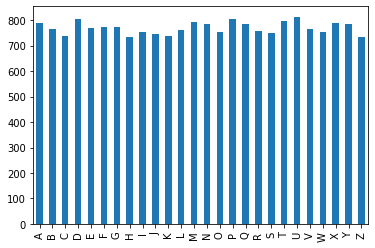

In [72]:
#Plot the Class Label distributions and the Feature distributions
#Class label distribution
label_dist = data.iloc[:,0].value_counts().sort_index() #create a table of counts 
label_dist.plot.bar() #balanced labels

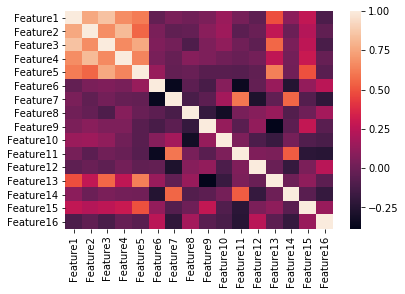

In [46]:
#Check correlation between features using a heat map
sns.heatmap(x.corr()) #Feataure 1-5 have much higher correlations than other features

In [73]:
##Section 2. Prepare data for modelling
n = data.shape[0]
k = 0.70
q = int(round(n*k))

#Standardize features and convert to numpy arrays
x = np.asarray(x).astype('float32')
x = (x - x.mean(axis = 0))/x.std(axis=0) #x is homogeneous (similar range) - mean 0, std 1
#x = (x - x.mean(axis = 0))/(x.max(axis=0) - x.min(axis=0))
#x = (x - x.min(axis = 0))/(x.max(axis=0) - x.min(axis=0)) #x takes on small values - lies in [0,1]

train_x = x[:q,:] 
test_x = x[q:,:] 

In [74]:
#1-hot-encode targets y and convert to numpy arrays
y = np.asarray(y) #objects
y = to_categorical(y)

train_y = y[:q,:]
test_y = y[q:,:]

In [49]:
#type(train_x), type(train_y), type(test_x), type(test_y) #(numpy.ndarray, numpy.ndarray, numpy.ndarray, numpy.ndarray)
#train_x.shape, train_y.shape, test_x.shape, test_y.shape #((14000, 16), (14000, 26), (6000, 16), (6000, 26))

In [56]:
##Section 4. Model Building
#1)Architecture of the model
n = 1000 # number of epochs
d = train_x.shape[1]
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(d,))) 
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(26, activation='softmax')) #26 classes
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) #Optimizer, Loss function, Metrics

#2)Train the model 
q = int(0.3*train_x.shape[0]) #70%-30% train vs dev 
x_val = train_x[:q] #train vs dev sets
partial_x_train = train_x[q:]
y_val = train_y[:q]
partial_y_train = train_y[q:]

history = model.fit(partial_x_train,partial_y_train,epochs=n,batch_size=512,validation_data=(x_val,y_val),
                   verbose=0) 
history_dict = history.history

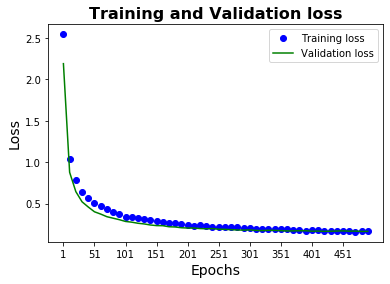

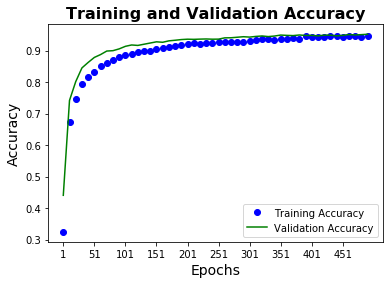

In [58]:
#3)Tuning - Plot loss and accuracy (training vs dev)
epochs = range(1,n+1,10)
loss_values = [history_dict['loss'][i] for i in epochs]
val_loss_values = [history_dict['val_loss'][i] for i in epochs]

plt.plot(epochs,loss_values, 'bo', label='Training loss')
plt.plot(epochs,val_loss_values, 'g', label='Validation loss')
plt.xticks(range(1, n, 50))
plt.title('Training and Validation loss', fontweight = 'bold',fontsize = 16)
plt.xlabel('Epochs',fontsize = 14)
plt.ylabel('Loss',fontsize = 14)
plt.legend()
plt.show()

acc = [history_dict['acc'][i] for i in epochs]
val_acc = [history_dict['val_acc'][i] for i in epochs]
plt.plot(epochs,acc, 'bo', label='Training Accuracy')
plt.plot(epochs,val_acc, 'g', label='Validation Accuracy')
plt.xticks(range(1, n, 50))
plt.title('Training and Validation Accuracy', fontweight = 'bold',fontsize = 16)
plt.xlabel('Epochs',fontsize = 14)
plt.ylabel('Accuracy',fontsize = 14)
plt.legend()
plt.show()

In [77]:
#4)Finalize - retraining the model using whole training set
d = train_x.shape[1]
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(d,))) 
model.add(layers.Dropout(0.1))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(26, activation='softmax')) #26 classes
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy']) #Optimizer, Loss function, Metrics

model.fit(train_x, train_y, epochs=350,batch_size=512,verbose=0)

In [78]:
#5)Evaluate on the test set
model.evaluate(test_x,test_y) #[loss, accuracy] = [0.1299247438168774, 0.9585]

6000/6000 [==============================] - 0s 78us/step


[0.12395635248720646, 0.9586666666666667]

In [ ]:
#6)Closer look at the test set performance
predictions = model.predict(test_x, verbose=0) #see the soft probability of the predicted data
plt.hist(predictions)

In [ ]:
#Random baseline model(multiclass classification)
test_y = np.asarray(data.iloc[q:,0])
test_y_copy = copy.copy(test_y)
np.random.shuffle(test_y_copy)
hits_array = np.array(test_y) == np.array(test_y_copy)
float(np.sum(hits_array))/len(test_y)

#a random guess tends to get an accuracy of 0.04063291139240506 